This notebook is for developing functions needed to calculate the dynamic windage and correction coeffecient. 

The dynamic coefficients are caluclated by solving the following equations:

### Dynamic winage
$$u_d = u_o + \alpha*u_a$$

Where $u_o$ is the ocean current vector, $u_a$ is the wind vector, $\alpha$ is the windage coefficient vector, and $u_d$ is the drifter velocity vector. 

The dynamic windage can then be calulcated as:
$$\alpha = \frac{u_d - u_o}{u_a}$$

In complex notation, the real part of $\alpha$ gives the along-wind correction and the imaginary part of $\alpha$ gives the across-wind correction.


# Plan

## 1. Drifter data
* Load drifter data
* Calculate speed
* Resample to hourly

## 2. Ocean data
* Load ocean data
* Rotate to east/north
* Interpolate to observed drifter locations/times
  * For each drifter time
    * Interpolate ocean data to timestamp
    * Identify closest grid cell to drifter location
    * Refine data to 10x10 neighbourhood
    * Use refined data to interpolate in space

  
## 3. Atmos data
* Load atmos data
* Interpolate to observed drifter locations/times
  * For each drifter time
    * Interpolate atmos data to timestamp
    * Identify closest grid cell to drifter location
    * Refine data to 10x10 neighbourhood
    * Use refined data to interpolate in space
    
## 4. Calculate $\alpha$

In [1]:
import cmath
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pyproj
import scipy.interpolate as interp
import xarray as xr

from driftutils.rotate_fields import rot_rep_2017_p
from driftutils.find_nearest_grid_point import find_nearest_grid_point

In [2]:
path='/home/soontiensn/data/gpsc-work2/OPP/dyanmic-windage-test/'

# 1. Drifter Data

## Load drifter data

In [3]:
fd=glob.glob(os.path.join(path,'drifters','*.nc'))
fd.sort()
fd

['/home/soontiensn/data/gpsc-work2/OPP/dyanmic-windage-test/drifters/wp3392541503D20160525.nc',
 '/home/soontiensn/data/gpsc-work2/OPP/dyanmic-windage-test/drifters/wp3792521692D20160525.nc',
 '/home/soontiensn/data/gpsc-work2/OPP/dyanmic-windage-test/drifters/wp4112522940D20160521.nc']

In [4]:
dd = xr.open_dataset(fd[0])
dd

<xarray.Dataset>
Dimensions:    (TIME: 1061)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2016-05-25T23:22:05 ... 2016-05-29T16:02:00
Data variables:
    LATITUDE   (TIME) float64 ...
    LONGITUDE  (TIME) float64 ...
Attributes:
    source:                        IOS, Ocean Sciences Division, Sidney, B.C.
    contact:                       Roy.Hourston@dfo-mpo.gc.ca
    platform_type:                 Drifting Buoy
    model:                         Surface Circulation Tracker
    buoyid:                        wp3392541503D20160525
    qc_comment:                    unspecified qc performed by the data provider
    nafc_qc_comment:               Additional quality control provided by NAF...
    original_data_source_comment:  The original dataset is available for down...
    approximate_drogue_depth:      0
    brand:                         Oceanetic Measurement
    serial_number:                 339
    original_filename:             sct0339_20160525_20160606.drf
    description

## Calculate speed

In [5]:
def drifter_velocity(d):
    """Calculate the time series of drifter velocity given a drifter dataset"""
    lon1 = d.LONGITUDE.values[0:-1]
    lon2 = d.LONGITUDE.values[1:]
    lat1 = d.LATITUDE.values[0:-1]
    lat2 = d.LATITUDE.values[1:]
    times = d.TIME.values[:]
    
    # Define a projection
    g = pyproj.Geod(ellps='WGS84')
    
    azimuth, backazimuth, dist = g.inv(lon1, lat1, lon2, lat2, radians=False)
    
    speed = []
    for i, d in enumerate(dist):
        speed.append(dist[i] /((times[i+1] - times[i])/np.timedelta64(1, 's')))
    speed = np.array(speed)
    
    u = speed*np.sin(np.radians(azimuth))
    v = speed*np.cos(np.radians(azimuth)) 
    
    # perhaps return a dataset? Maybe even save it??
    ds = xr.Dataset(coords={'time': times[0:-1]},
                    data_vars={'lon': ('time', lon1),
                               'lat': ('time', lat1),
                               'u': ('time', u),
                               'v': ('time', v)})
    return ds
    

In [6]:
ds = drifter_velocity(dd)

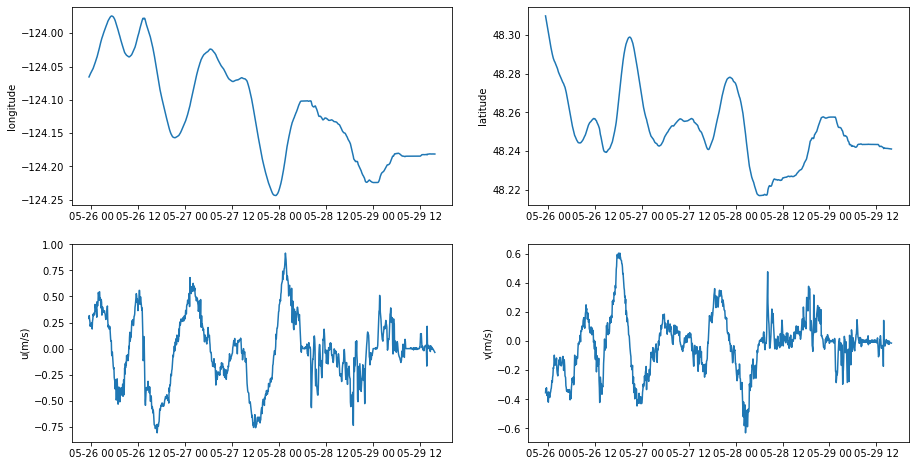

In [7]:
fig,axs = plt.subplots(2,2,figsize=(15,8))
for ax, var, name in zip(axs.flatten(), [ds.lon, ds.lat, ds.u, ds.v], ['longitude', 'latitude', 'u(m/s)', 'v(m/s)']):
    ax.plot(ds.time, var)
    ax.set_ylabel(name)

Velocities are a bit noisy...

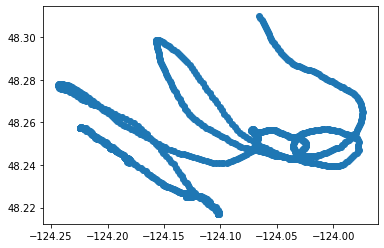

In [8]:
plt.plot(ds.lon,ds.lat,'o')

## Resample to hourly
Best to resample the drifter track to hourly to make the specrtral analysis easier.

In [9]:
dsresample = ds.resample({'time': '1H'}).interpolate('linear').dropna('time')
print(dsresample)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 88)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-26 ... 2016-05-29T15:00:00
Data variables:
    lon      (time) float64 -124.1 -124.0 -124.0 -124.0 ... -124.2 -124.2 -124.2
    lat      (time) float64 48.3 48.29 48.28 48.28 ... 48.24 48.24 48.24 48.24
    u        (time) float64 0.2445 0.4013 0.5391 ... -0.0146 0.0174 0.007966
    v        (time) float64 -0.4065 -0.275 -0.1412 ... 0.02351 -0.0162 -0.005448
<xarray.Dataset>
Dimensions:  (time: 1060)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-25T23:22:05 ... 2016-05-29T15:50:43
Data variables:
    lon      (time) float64 -124.1 -124.1 -124.1 -124.1 ... -124.2 -124.2 -124.2
    lat      (time) float64 48.31 48.31 48.31 48.31 ... 48.24 48.24 48.24 48.24
    u        (time) float64 0.2893 0.3165 0.2794 ... 0.0 -0.003439 -0.03621
    v        (time) float64 -0.3553 -0.3299 -0.3466 ... -0.0 -0.0103 -0.01314


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/core/common.py:843: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  loffset))


In [10]:
# truncate to when we have model data
dsresample = dsresample.sel(time=slice('2016-05-25','2016-05-29 00:00:00'))
dsresample

<xarray.Dataset>
Dimensions:  (time: 73)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-26 2016-05-26T01:00:00 ... 2016-05-29
Data variables:
    lon      (time) float64 -124.1 -124.0 -124.0 -124.0 ... -124.2 -124.2 -124.2
    lat      (time) float64 48.3 48.29 48.28 48.28 ... 48.25 48.26 48.26 48.26
    u        (time) float64 0.2445 0.4013 0.5391 ... -0.3217 0.03365 -0.01654
    v        (time) float64 -0.4065 -0.275 -0.1412 ... 0.04066 0.01134 -0.01121

# 2. Ocean Data

## Load ocean data

In [11]:
fou = glob.glob(os.path.join(path, 'ocean', '*grid_U*.nc'))
fou.sort()
fov = glob.glob(os.path.join(path, 'ocean', '*grid_V*.nc'))
fov.sort()
du = xr.open_mfdataset(fou)
dv = xr.open_mfdataset(fov)

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/backend

In [12]:
mfile='/home/soontiensn/data/gpsc-work2/models/SalishSea-BC12/mesh_mask201702MD.nc'
mesh=xr.open_dataset(mfile)

In [13]:
u=du.isel(depthu=0).vozocrtx
v=dv.isel(depthv=0).vomecrty
lonu=np.squeeze(mesh.glamu.values)
latu=np.squeeze(mesh.gphiu.values)
lonv=np.squeeze(mesh.glamv.values)
latv=np.squeeze(mesh.gphiv.values)


## Rotate to east/north

In [14]:
# load the rotation file
rfile='/home/soontiensn/data/gpsc-work2/rotation_pickles/SalishSea-BC12/salishsea.rotate.pickle'
with open(rfile, 'rb') as f:
    coeffs=pickle.load(f)
    

In [15]:
ueast = rot_rep_2017_p(u,v,'U','ij->e', coeffs)
vnorth = rot_rep_2017_p(u,v,'V','ij->n', coeffs)

## Interpolate to observed drifter locations/time

In [16]:
# test time stamp for interp
t_test = 0

### Interpolate in time

In [17]:
def interpolate_time(var, t, ti):
    """Interpolate var(t) to time ti. Linear interpolation in time. 
    var is an array of data with first index time (eg. [time, y, x])
    ti is a np.datetime64 object
    t is an array of np.datetime64 objects
    """
    
    # Define a reference time
    epoc = t[0] 
    # t and ti with repsect to epoc in seconds
    ti_wrt_epoc = (ti-epoc)/np.timedelta64(1, 's')
    t_wrt_epoc = (t-epoc)/np.timedelta64(1, 's')
    
    # Identify neighbouring time indices
    diff = ti_wrt_epoc - t_wrt_epoc
    i1 = np.argmin(np.abs(diff))
    sign = np.sign(diff[i1])
    i2 = int(i1 + sign*1)
    
    # Ensure i2 is in a valid range. In these cases, extrapolation will occur... perhaps send a warning??
    if i1 == 0:
        i2 = i1 + 1
    elif i1 == len(t_wrt_epoc) -1:
        i2 = i1 - 1
        
    # Edge case when i1 = i2 (sign is 0)
    if i1 == i2:
        vari = var[i1]
    else:
        # Interpolate
        vari = var[i1] + (var[i2] - var[i1])/(t_wrt_epoc[i2] - t_wrt_epoc[i1])*(ti_wrt_epoc-t_wrt_epoc[i1])
    return vari

In [18]:
ueasti = interpolate_time(ueast, du.time_counter.values, dsresample.time.values[t_test])
vnorthi = interpolate_time(vnorth, dv.time_counter.values, dsresample.time.values[t_test])

### Identify closest grid cells to drifter location/Interpolate in space

In [19]:
def interpolate_space(var, lon, lat, loni, lati):
    """ Interpolate field var(lon, lat) to (loni, lati)"""
    f = interp.interp2d(lon, lat, var)
    vari=f(loni,lati)
    return vari
    

In [20]:
dist, j, i, lat_near, lon_near = find_nearest_grid_point(dsresample.lat.values[t_test], 
                                                         dsresample.lon.values[t_test], 
                                                         mesh, 
                                                         'gphiu', 
                                                         'glamu',
                                                         n=10)
ueastis = interpolate_space(ueasti[j,i], lonu[j,i], latu[j,i], dsresample.lon.values[t_test], dsresample.lat.values[t_test])
print(ueastis)

[0.36229473]


In [21]:
dist, j, i, lat_near, lon_near = find_nearest_grid_point(dsresample.lat.values[t_test], 
                                                         dsresample.lon.values[t_test], 
                                                         mesh, 
                                                         'gphiv', 
                                                         'glamv',
                                                         n=10)
vnorthi = interpolate_space(vnorthi[j,i], lonv[j,i], latv[j,i], dsresample.lon.values[t_test], dsresample.lat.values[t_test])
print(vnorthi)

[-0.2860269]


## Interpolation for loop

In [22]:
def interpolate_variable_to_obs_track(dobs, dmodel, lon_var, lat_var, grid_dataset):
    vari_ts_array = []
    lon_mod = np.squeeze(grid_dataset[lon_var].values)
    lat_mod = np.squeeze(grid_dataset[lat_var].values)
    for t in range(len(dobs.time.values)):
        loni = dobs.lon.values[t]
        lati = dobs.lat.values[t]
        ti = dobs.time.values[t]
        # Interpolate in time
        vari_t = interpolate_time(dmodel, dmodel.time_counter.values, ti)
        # Identify closest grid cell and interpolate in space
        dist, j, i, lat_near, lon_near = find_nearest_grid_point(lati, loni, grid_dataset, lat_var,lon_var,n=10)
        vari_ts = interpolate_space(vari_t[j,i], lon_mod[j,i], lat_mod[j,i], loni, lati)
        vari_ts_array.append(vari_ts[0])
    ds_vari_ts = xr.Dataset(coords={'time': dobs.time.values},
                            data_vars={'lon': ('time', dobs.lon.values),
                                       'lat': ('time', dobs.lat.values),
                                       'vari_ts': ('time', np.array(vari_ts_array)),})
    return ds_vari_ts

In [23]:
do_uinterp = interpolate_variable_to_obs_track(dsresample, ueast, 'glamu', 'gphiu', mesh)
do_uinterp = do_uinterp.rename({'vari_ts': 'ueast_ocean'})

In [24]:
do_vinterp = interpolate_variable_to_obs_track(dsresample, vnorth, 'glamv', 'gphiv', mesh)
do_vinterp = do_vinterp.rename({'vari_ts': 'vnorth_ocean'})

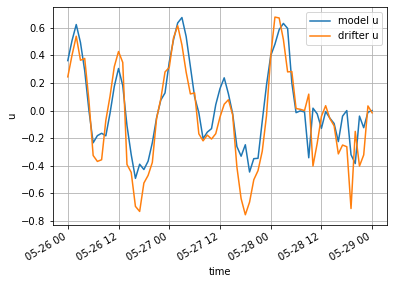

In [25]:
fig,ax = plt.subplots(1,1)
do_uinterp.ueast_ocean.plot(ax=ax, label='model u')
dsresample.u.plot(ax=ax,label='drifter u')
ax.legend()
ax.grid()

Note, only have mdodel data to May 29 00:00.  So need some checks that we don't extrapolate or need to limit timeframe for interpolation to exclude data outside of model's range.

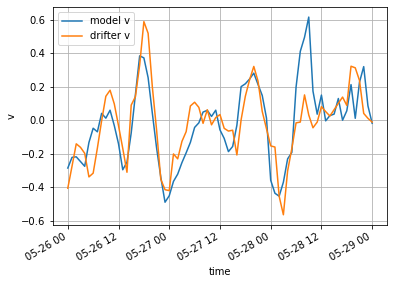

In [26]:
fig,ax = plt.subplots(1,1)
do_vinterp.vnorth_ocean.plot(ax=ax,label='model v')
dsresample.v.plot(ax=ax,label='drifter v')
ax.legend()
ax.grid()

# 3. Atmos data

## Load atmos data

In [27]:
fa=glob.glob(os.path.join(path, 'atmos', '*.nc'))
fa.sort()
da = xr.open_mfdataset(fa, concat_dim='time_counter', data_vars='minimal')


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [28]:
da_uinterp = interpolate_variable_to_obs_track(dsresample, da.u_wind, 'nav_lon', 'nav_lat', da)
da_uinterp = da_uinterp.rename({'vari_ts': 'ueast_atmos'})

In [29]:
da_vinterp = interpolate_variable_to_obs_track(dsresample, da.v_wind, 'nav_lon', 'nav_lat', da)
da_vinterp = da_vinterp.rename({'vari_ts': 'vnorth_atmos'})

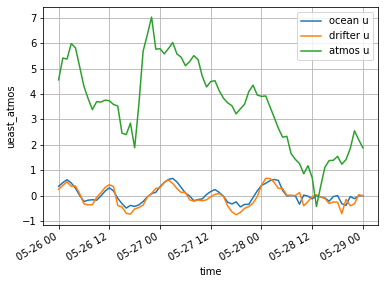

In [30]:
fig,ax = plt.subplots(1,1)
do_uinterp.ueast_ocean.plot(ax=ax, label='ocean u')
dsresample.u.plot(ax=ax,label='drifter u')
da_uinterp.ueast_atmos.plot(ax=ax, label='atmos u')
ax.legend()
ax.grid()

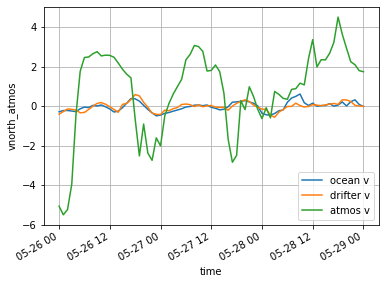

In [31]:
fig,ax = plt.subplots(1,1)
do_vinterp.vnorth_ocean.plot(ax=ax, label='ocean v')
dsresample.v.plot(ax=ax,label='drifter v')
da_vinterp.vnorth_atmos.plot(ax=ax, label='atmos v')
ax.legend()
ax.grid()

# 4. Calculate $\alpha$

In [32]:
n = len(do_vinterp.vnorth_ocean.values)
ocean = np.array([complex(do_uinterp.ueast_ocean.values[i], do_vinterp.vnorth_ocean.values[i]) for i in range(n)])
atmos = np.array([complex(da_uinterp.ueast_atmos.values[i], da_vinterp.vnorth_atmos.values[i]) for i in range(n)])
drift = np.array([complex(dsresample.u.values[i], dsresample.v.values[i]) for i in range(n)])

In [33]:
alpha = (ocean - drift)/atmos

In [34]:
np.mean(alpha.real)

0.023138216555713367

In [35]:
np.mean(alpha.imag)

0.0004287601988646891